elem.x shape: (68,), elem.y shape: (68,)
node.x shape: (69,), node.y shape: (69,)
Sol.rho shape: (68, 68)
mpv.p2_nodes shape: (69, 69)
Shape of inner_x_coords for plot: (64,)
Shape of inner_y_coords for plot: (64,)
Shape of rhou_to_plot: (64, 64)


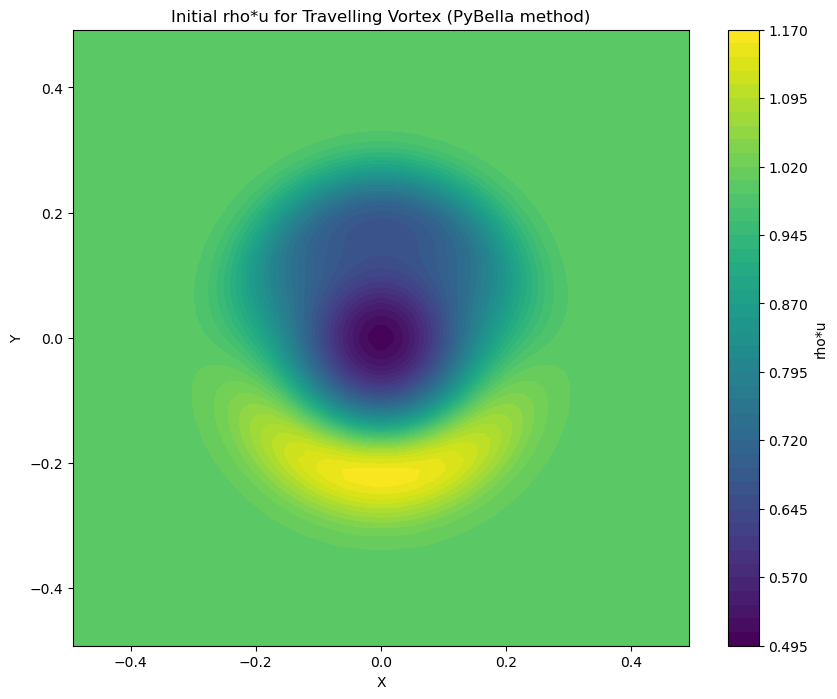

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Simplified Options/Enums (mimicking dycore.utils.options)
class BdryType:
    PERIODIC = 1
    WALL = 2
    # Add others if sol_init depends on them, but for vortex, periodic is key.

class LimiterType: # Not directly used in sol_init but part of UserData
    NONE = 0

# Simplified Thermodynamics (mimicking dycore.physics.gas_dynamics.thermodynamic.init)
class Thermodynamics:
    def __init__(self, gamma):
        self.gamma = gamma
        self.gamm = gamma # PyBella uses self.gamm
        self.gm1 = gamma - 1.0
        self.gm1inv = 1.0 / (gamma - 1.0)
        self.Gammainv = self.gamma # In PyBella, p = rhoY**gamm, so rhoY = p**(1/gamm) = p**Gammainv
                                   # This seems to imply Gammainv = 1/gamma, but the pressure calc uses p**th.gamminv
                                   # Let's stick to how it's used: rhoY = p**th.gamminv
        self.Gammainv = 1.0 / self.gamma # Correcting based on typical Exner relation usage
                                         # p_exner = (P_actual / P_ref)^(R/cp)
                                         # rhoY is often related to p_exner or a power of it.
                                         # If rhoY = p_exner, and p_exner = P^(R/cp),
                                         # and R/cp = (cp-cv)/cp = 1 - 1/gamma.
                                         # If rhoY = P_thermo ^ (1/gamma) for some normalization, then gamminv is 1/gamma.
                                         # PyBella's rhoY = p**th.gamminv where p is pressure.
                                         # This is consistent with p being non-dim pressure and rhoY being non-dim Exner pressure.
                                         # So, if p is P/P_ref and rhoY is (P/P_ref)^( (gamma-1)/gamma ), then gamminv = (gamma-1)/gamma.
                                         # However, the code uses Sol.rhoY[:, igy:-igy] = p**th.gamminv
                                         # and p = p0 + ud.Msq * fac**2 * dp2c.
                                         # This suggests rhoY is indeed Exner pressure raised to some power.
                                         # Let's assume th.gamminv is (gamma-1)/gamma as is standard for Exner pressure relation to Theta.
                                         # And th.Gamma is gamma.
        self.Gamma = gamma # For consistency with PyBella's dpi calculation: th.Gamma * g
        self.gm1inv = 1.0 / (self.gamma - 1.0) # Used for rhoY = ((Sol.rhoY[nlast]**th.gm1) + dpi)**th.gm1inv in reflective BC
                                               # This implies rhoY is (Pressure_Exner)^(gamma/(gamma-1)) or similar.
                                               # Let's re-evaluate based on Traveling Vortex specific init:
                                               # Sol.rhoY[:, igy:-igy] = p**th.gamminv
                                               # where p = p0 + ud.Msq * fac**2 * dp2c
                                               # This 'p' is a perturbed non-dimensional pressure.
                                               # If rhoY is truly rho*Theta, and Theta = (P/P_ref)^((gamma-1)/gamma) / (rho * R_gas/P_ref)
                                               # then rhoY = (P/P_ref)^((gamma-1)/gamma) * P_ref / R_gas
                                               # If rhoY is Exner pressure Pi, then Pi = (P/P_ref)^((gamma-1)/gamma)
                                               # So rhoY = p_nd^((gamma-1)/gamma).  th.gamminv = (gamma-1)/gamma
        self.gamminv = (self.gamma - 1.0) / self.gamma # Standard for Exner pressure from pressure ratio


# Simplified Grid Structure (mimicking discretization.kgrid)
class GridBase:
    def __init__(self, nx_cells, ny_cells, x_min, x_max, y_min, y_max, ng):
        self.nx = nx_cells # Number of physical cells
        self.ny = ny_cells
        self.ng = ng # Number of ghost cells on each side

        self.dx = (x_max - x_min) / nx_cells
        self.dy = (y_max - y_min) / ny_cells

        # Total cells including ghosts
        self.ncx_total = nx_cells + 2 * ng
        self.ncy_total = ny_cells + 2 * ng

        # Cell-centered coordinates (full domain including ghosts)
        self.x_cells = np.linspace(
            x_min - ng * self.dx + 0.5 * self.dx,
            x_max + (ng - 0.5) * self.dx, # Corrected end for linspace
            self.ncx_total,
        )
        self.y_cells = np.linspace(
            y_min - ng * self.dy + 0.5 * self.dy,
            y_max + (ng - 0.5) * self.dy, # Corrected end for linspace
            self.ncy_total,
        )
        # Node-centered coordinates (full domain including ghosts)
        # Nodes are n_cells + 1. So total nodes = n_cells_total + 1
        self.x_nodes = np.linspace(
            x_min - ng * self.dx,
            x_max + ng * self.dx,
            self.ncx_total + 1,
        )
        self.y_nodes = np.linspace(
            y_min - ng * self.dy,
            y_max + ng * self.dy,
            self.ncy_total + 1,
        )

        # For PyBella's elem/node structure (igs needs to be a list for get_ghost_padding)
        self.igs = [ng, ng, 0] # Assuming 2D, ngz=0
        self.igx = ng
        self.igy = ng
        self.igz = 0 # For 2D
        self.icx = self.ncx_total # PyBella's elem.icx is total cells
        self.icy = self.ncy_total
        self.icz = 1 # For 2D

        self.dxyz = [self.dx, self.dy, 0.0] # For grad_nodes

        # Slices for inner domain (PyBella style)
        self.i2 = (slice(ng, -ng), slice(ng, -ng)) # For accessing inner physical domain

class ElemSpaceDiscr(GridBase): # PyBella's elem
    def __init__(self, nx_cells, ny_cells, x_min, x_max, y_min, y_max, ng):
        super().__init__(nx_cells, ny_cells, x_min, x_max, y_min, y_max, ng)
        self.x = self.x_cells
        self.y = self.y_cells
        self.sc = (self.ncx_total, self.ncy_total) # Shape of cell-centered arrays

class NodeSpaceDiscr(GridBase): # PyBella's node
     def __init__(self, nx_cells, ny_cells, x_min, x_max, y_min, y_max, ng):
        super().__init__(nx_cells, ny_cells, x_min, x_max, y_min, y_max, ng)
        self.x = self.x_nodes
        self.y = self.y_nodes
        self.sc = (self.ncx_total + 1, self.ncy_total + 1) # Shape of node-centered arrays
        # PyBella's node.i2 might be different if it refers to inner nodes for laplacian etc.
        # For p2_nodes access in sol_init, it seems to use igxn: -igxn
        self.i2 = (slice(ng, -(ng)), slice(ng, -(ng))) # Inner nodes, excluding outermost ghost nodes


# Simplified Solution Data Container (mimicking management.variable.Vars)
class SolVars:
    def __init__(self, shape_cells, nspec=1):
        self.rho = np.zeros(shape_cells)
        self.rhou = np.zeros(shape_cells)
        self.rhov = np.zeros(shape_cells)
        self.rhow = np.zeros(shape_cells) # For 2D, this will be zero
        self.rhoY = np.zeros(shape_cells)
        self.rhoX = np.zeros(shape_cells) # Assuming nspec=1 for simplicity here

# Simplified MPV (mimicking physics.low_mach.mpv.MPV)
class MPV:
    def __init__(self, shape_cells, shape_nodes, elem_grid_1d_shape_y): # elem_grid_1d_y for HydroState
        self.p2_cells = np.zeros(shape_cells)
        self.p2_nodes = np.zeros(shape_nodes)
        # Simplified HydroState: just need p0 and rhoY0 for cells and nodes (1D in y)
        self.HydroState = type('HydroState', (), {})() # Empty object
        self.HydroState.p0 = np.ones(elem_grid_1d_shape_y) # Filled by hydrostatic_state
        self.HydroState.rhoY0 = np.ones(elem_grid_1d_shape_y)

        self.HydroState_n = type('HydroState_n', (), {})() # Empty object for nodal hydrostatics
        self.HydroState_n.rhoY0 = np.ones(elem_grid_1d_shape_y + 1) # Nodal version has one more point

# Simplified UserData (mimicking inputs.test_travelling_vortex.UserData)
class UserData:
    def __init__(self):
        self.NSPEC = 1
        self.grav = 0.0
        self.gamma = 1.4
        self.R_gas = 287.4 # Not directly used in this sol_init, but good for context
        self.T_ref = 300.0

        self.Msq = 0.115 # Example, calculated from u_ref, R_gas, T_ref in full UserData
                        # For vortex, Msq scales pressure perturbation.
                        # u_ref = 100, R_gas = 287.4, T_ref = 300 -> Msq = 100^2 / (287.4*300) = 0.116
        self.u_ref = 100.0 # from h_ref/t_ref = 10000/100

        self.xmin = -0.5
        self.xmax = 0.5
        self.ymin = -0.5
        self.ymax = 0.5
        self.zmin = -0.5 # Not used for 2D
        self.zmax = 0.5

        self.u_wind_speed = 1.0
        self.v_wind_speed = 1.0
        self.w_wind_speed = 0.0 # For 2D

        self.bdry_type = np.empty((3), dtype=object)
        self.bdry_type[0] = BdryType.PERIODIC
        self.bdry_type[1] = BdryType.PERIODIC
        self.bdry_type[2] = BdryType.WALL # Default for 3rd dim if not used

        self.inx = 64 + 1 # PyBella defines inx, iny as number of nodes
        self.iny = 64 + 1
        self.inz = 1      # For 2D

        self.is_compressible = 1 # Affects how rhoY is set

        self.gravity_strength = np.zeros(3) # Vortex case has zero gravity

        # For boundary conditions (simplified)
        self.coriolis_strength = np.zeros(3) # Not used in this sol_init directly
        self.stratification = lambda y_coords: np.ones_like(y_coords) # Vortex is isentropic background

# Simplified hydrostatic_state (mimicking physics.hydrostatics.state)
def hydrostatic_state_simplified(mpv, elem, node, th, ud):
    # For zero gravity (vortex case), hydrostatic state is trivial:
    # p0 = 1.0, rhoY0 = 1.0 (non-dimensional)
    mpv.HydroState.p0[:] = 1.0
    mpv.HydroState.rhoY0[:] = 1.0
    mpv.HydroState_n.rhoY0[:] = 1.0 # For nodal hydrostate
    # In PyBella, these would be 1D arrays corresponding to the y-dimension of elem/node

# Simplified boundary functions (mimicking dycore.utils.boundary)
def set_explicit_boundary_data(Sol, elem, ud, th, mpv):
    # For a doubly periodic domain, this function might not do much if sol_init
    # already produces periodic-compatible values extending into ghosts.
    # However, a full implementation would handle ghost cell filling.
    # For this standalone, we'll assume sol_init correctly fills ghosts for periodic.
    # If wall boundaries were used, this would be critical.
    # Let's add a basic periodic fill for rho and rhou as an example.
    ng = elem.ng
    # X-direction periodic
    Sol.rho[:ng, :] = Sol.rho[-2*ng:-ng, :]
    Sol.rho[-ng:, :] = Sol.rho[ng:2*ng, :]
    Sol.rhou[:ng, :] = Sol.rhou[-2*ng:-ng, :]
    Sol.rhou[-ng:, :] = Sol.rhou[ng:2*ng, :]
    # Y-direction periodic
    Sol.rho[:, :ng] = Sol.rho[:, -2*ng:-ng]
    Sol.rho[:, -ng:] = Sol.rho[:, ng:2*ng]
    Sol.rhou[:, :ng] = Sol.rhou[:, -2*ng:-ng]
    Sol.rhou[:, -ng:] = Sol.rhou[:, ng:2*ng]
    # ... and for rhov, rhoY etc. ...
    Sol.rhov[:ng, :] = Sol.rhov[-2*ng:-ng, :]
    Sol.rhov[-ng:, :] = Sol.rhov[ng:2*ng, :]
    Sol.rhov[:, :ng] = Sol.rhov[:, -2*ng:-ng]
    Sol.rhov[:, -ng:] = Sol.rhov[:, ng:2*ng]

    Sol.rhoY[:ng, :] = Sol.rhoY[-2*ng:-ng, :]
    Sol.rhoY[-ng:, :] = Sol.rhoY[ng:2*ng, :]
    Sol.rhoY[:, :ng] = Sol.rhoY[:, -2*ng:-ng]
    Sol.rhoY[:, -ng:] = Sol.rhoY[:, ng:2*ng]


def set_ghostcells_p2(p2_array, elem, ud):
    # Simplified periodic fill for p2_cells
    ng = elem.ng
    p2_array[:ng, :] = p2_array[-2*ng:-ng, :]
    p2_array[-ng:, :] = p2_array[ng:2*ng, :]
    p2_array[:, :ng] = p2_array[:, -2*ng:-ng]
    p2_array[:, -ng:] = p2_array[:, ng:2*ng]

def set_ghostnodes_p2(p2_array, node, ud):
    # Simplified periodic fill for p2_nodes
    ng = node.ng
    p2_array[:ng, :] = p2_array[-2*ng-1:-ng-1, :] # Node arrays are +1 in size
    p2_array[-ng:, :] = p2_array[ng+1:2*ng+1, :]
    p2_array[:, :ng] = p2_array[:, -2*ng-1:-ng-1]
    p2_array[:, -ng:] = p2_array[:, ng+1:2*ng+1]


# The core sol_init function from PyBella's test_travelling_vortex.py
def sol_init_pybella_vortex(Sol, mpv, elem, node, th, ud):
    u0 = ud.u_wind_speed
    v0 = ud.v_wind_speed
    w0 = 0.0 # For 2D

    rotdir = 1.0
    p0 = 1.0
    alpha = -1.0
    alpha_const = 3.0
    rho0 = 1.0
    del_rho = -0.5
    R0 = 0.4
    fac = 1.0 * 1024.0
    xc = 0.0
    yc = 0.0

    # PyBella's elem.igs is a list [igx, igy, igz]
    # elem.igy is just igs[1]
    igy = elem.igs[1] # Ghost cells in y for slicing Sol arrays if needed for hydrostate
    igx = elem.igs[0] # Ghost cells in x

    igxn = node.igs[0] # Ghost cells in x for node arrays
    igyn = node.igs[1] # Ghost cells in y for node arrays

    hydrostatic_state_simplified(mpv, elem, node, th, ud) # Simplified for vortex

    coe = np.array([
        1.0/24.0, -6.0/13.0, 15.0/7.0, -74.0/15.0, 57.0/16.0, 174.0/17.0, -269.0/9.0,
        450.0/19.0, 1071.0/40.0, -1564.0/21.0, 510.0/11.0, 1020.0/23.0, -1105.0/12.0,
        204.0/5.0, 510.0/13.0, -1564.0/27.0, 153.0/8.0, 450.0/29.0, -269.0/15.0,
        174.0/31.0, 57.0/32.0, -74.0/33.0, 15.0/17.0, -6.0/35.0, 1.0/72.0
    ])
    const_coe = np.array([
        1.0/24, -6.0/13, 33.0/14, -22.0/3, 495.0/32, -396.0/17, +77.0/3,
        -396.0/19, 99.0/8, -110.0/21, +3.0/2, -6.0/23, +1.0/48
    ])

    # elem.x and elem.y are 1D arrays of cell-centers (including ghosts)
    # Create 2D mesh for calculations on the full grid
    # PyBella: xs = elem.x.reshape(-1,1), ys = elem.y[igy:-igy].reshape(1,-1)
    # This slicing for ys implies that the hydrostate p0 and rhoY were only for the inner y-domain.
    # However, for the vortex, hydrostate is trivial (1.0 everywhere).
    # For consistency with PyBella's r calculation, let's use full grid coords.
    # The periodic boundary handling will make the actual values wrap around.

    # Full grid cell-centered coordinates
    X_cells, Y_cells = np.meshgrid(elem.x, elem.y, indexing='ij')

    # Handle periodicity for distance calculation
    Lx = ud.xmax - ud.xmin
    Ly = ud.ymax - ud.ymin

    dx_c = X_cells - xc
    dy_c = Y_cells - yc
    dx_c = dx_c - Lx * np.round(dx_c / Lx) # Closest image for periodic domain
    dy_c = dy_c - Ly * np.round(dy_c / Ly)

    r_c = np.sqrt(dx_c**2 + dy_c**2)
    r_over_R0_c = np.divide(r_c, R0, where=R0!=0)

    uth_c = np.zeros_like(r_c)
    mask_c = (r_c < R0) & (r_c > 1e-9) # Avoid division by zero at center
    uth_c[mask_c] = (rotdir * fac * (1.0 - r_over_R0_c[mask_c])**6 * r_over_R0_c[mask_c]**6)

    u_pert_c = np.zeros_like(uth_c)
    v_pert_c = np.zeros_like(uth_c)
    u_pert_c[mask_c] = uth_c[mask_c] * (-dy_c[mask_c] / r_c[mask_c])
    v_pert_c[mask_c] = uth_c[mask_c] * (+dx_c[mask_c] / r_c[mask_c])

    u_total_c = u0 + u_pert_c
    v_total_c = v0 + v_pert_c
    w_total_c = w0 # Remains zero for 2D

    rho_total_c = np.full_like(r_c, rho0)
    mask_rho_c = r_c < R0
    rho_total_c[mask_rho_c] += del_rho * (1.0 - r_over_R0_c[mask_rho_c]**2)**6

    dp2c_sum = np.zeros_like(r_c)
    if ud.Msq > 1e-10: # Only if compressible and vortex has strength
        for ip_idx, c_val in enumerate(coe):
            term = c_val * (r_over_R0_c**(12 + ip_idx) - 1.0) * rotdir**2
            dp2c_sum[mask_rho_c] += term[mask_rho_c]

        dp2c_const_sum = np.zeros_like(r_c)
        for ip_idx, c_val in enumerate(const_coe):
            term = c_val * (r_over_R0_c**(12 + ip_idx) - 1.0) * rotdir**2
            dp2c_const_sum[mask_rho_c] += term[mask_rho_c]

        dp2c = alpha * dp2c_sum + alpha_const * dp2c_const_sum
    else:
        dp2c = np.zeros_like(r_c)


    # Assign to Solution object (full arrays, including ghosts)
    Sol.rho[:,:] = rho_total_c
    Sol.rhou[:,:] = rho_total_c * u_total_c
    Sol.rhov[:,:] = rho_total_c * v_total_c
    Sol.rhow[:,:] = rho_total_c * w_total_c # Will be zero for 2D

    if ud.is_compressible:
        p_perturbed_c = p0 + ud.Msq * fac**2 * dp2c
        Sol.rhoY[:,:] = p_perturbed_c**th.gamminv
    else:
        # For incompressible or Boussinesq, rhoY might be rho * Theta_background
        # For vortex, background is isentropic, rhoY0 = 1.0
        # PyBella: Sol.rhoY[:, igy:-igy] = rhoY (where rhoY was mpv.HydroState.rhoY0)
        # This implies rhoY is simply the background rhoY, not perturbed by pressure.
        # However, the line above for compressible does perturb it.
        # Let's follow the compressible branch for consistency with PyBella's vortex setup.
        # If it were incompressible, rhoY would be based on background stratification.
        # For the vortex, background rhoY0 is 1.0.
        Sol.rhoY[:,:] = np.ones_like(rho_total_c) * mpv.HydroState.rhoY0[0] # Use the constant background

    # p2_cells (dynamic pressure perturbation for the solver)
    # PyBella: mpv.p2_cells[:, igy:-igy] = th.Gamma * fac**2 * np.divide(p2c, mpv.HydroState.rhoY0[igy:-igy])
    # p2c here is the unscaled sum (alpha * dp2c_sum + alpha_const * dp2c_const_sum)
    # For vortex, mpv.HydroState.rhoY0 is 1.0
    mpv.p2_cells[:,:] = th.Gamma * fac**2 * dp2c / mpv.HydroState.rhoY0[0] # rhoY0 is scalar 1.0

    set_ghostcells_p2(mpv.p2_cells, elem, ud)

    # --- Nodal pressure p2_nodes ---
    # Full grid node-centered coordinates
    X_nodes, Y_nodes = np.meshgrid(node.x, node.y, indexing='ij')

    dx_n = X_nodes - xc
    dy_n = Y_nodes - yc
    dx_n = dx_n - Lx * np.round(dx_n / Lx)
    dy_n = dy_n - Ly * np.round(dy_n / Ly)

    r_n = np.sqrt(dx_n**2 + dy_n**2)
    r_over_R0_n = np.divide(r_n, R0, where=R0!=0)
    mask_n = r_n < R0

    p2_nodes_sum = np.zeros_like(r_n)
    for ip_idx, c_val in enumerate(coe):
        term = c_val * (r_over_R0_n**(12 + ip_idx) - 1.0) * rotdir**2
        p2_nodes_sum[mask_n] += term[mask_n]

    p2_nodes_const_sum = np.zeros_like(r_n)
    for ip_idx, c_val in enumerate(const_coe):
        term = c_val * (r_over_R0_n**(12 + ip_idx) - 1.0) * rotdir**2
        p2_nodes_const_sum[mask_n] += term[mask_n]

    p2n_unscaled = alpha * p2_nodes_sum + alpha_const * p2_nodes_const_sum

    # PyBella: mpv.p2_nodes[igxn:-igxn, igyn:-igyn] = th.Gamma * fac**2 * np.divide(
    # mpv.p2_nodes[igxn:-igxn, igyn:-igyn], mpv.HydroState_n.rhoY0[igyn : -igyn + 1] )
    # Here mpv.p2_nodes was used to accumulate the sum, which is p2n_unscaled for us.
    # mpv.HydroState_n.rhoY0 is 1.0 for vortex.
    mpv.p2_nodes[:,:] = th.Gamma * fac**2 * p2n_unscaled / mpv.HydroState_n.rhoY0[0]

    set_ghostnodes_p2(mpv.p2_nodes, node, ud)

    # This is crucial: apply boundary conditions to Sol variables AFTER initial fill
    set_explicit_boundary_data(Sol, elem, ud, th, mpv)

    # Initial projection part from PyBella is skipped as per original request for standalone init.

    return Sol
# Main script part
if __name__ == "__main__":
    ud = UserData()
    th = Thermodynamics(ud.gamma)

    # Grid setup
    # PyBella's inx,iny are number of nodes. nx_cells = inx-1.
    nx_cells = ud.inx - 1
    ny_cells = ud.iny - 1
    num_ghost_cells = 2 # Standard ghost cells

    elem = ElemSpaceDiscr(nx_cells, ny_cells, ud.xmin, ud.xmax, ud.ymin, ud.ymax, num_ghost_cells)
    node = NodeSpaceDiscr(nx_cells, ny_cells, ud.xmin, ud.xmax, ud.ymin, ud.ymax, num_ghost_cells)

    # Solution and MPV objects
    # Shapes are (total_x_cells, total_y_cells) and (total_x_nodes, total_y_nodes)
    sol_shape_cells = (elem.ncx_total, elem.ncy_total)
    sol_shape_nodes = (node.ncx_total +1, node.ncy_total+1) # node.x/y are nodal coords, so shape is +1

    # For HydroState, it's 1D along y, with total y-cells/nodes
    hydro_shape_cells_y = elem.ncy_total
    hydro_shape_nodes_y = node.ncy_total + 1


    Sol = SolVars(sol_shape_cells, ud.NSPEC)
    mpv = MPV(sol_shape_cells, sol_shape_nodes, hydro_shape_cells_y)


    print(f"elem.x shape: {elem.x.shape}, elem.y shape: {elem.y.shape}")
    print(f"node.x shape: {node.x.shape}, node.y shape: {node.y.shape}")
    print(f"Sol.rho shape: {Sol.rho.shape}")
    print(f"mpv.p2_nodes shape: {mpv.p2_nodes.shape}")


    # Initialize solution
    sol_init_pybella_vortex(Sol, mpv, elem, node, th, ud)

    # Plot rhou
    fig, ax = plt.subplots(figsize=(10, 8))

    # We want to plot the physical domain, so slice out ghost cells for plotting
    # elem.x and elem.y already include ghost cells.
    # For plotting, we need the coordinates of the cells we are plotting.
    # If Sol.rhou is (total_nx, total_ny), then elem.x and elem.y are the correct coords.
    # However, usually one plots the "inner" or "physical" domain.

    inner_x_coords = elem.x[elem.igs[0] : -elem.igs[0]]
    inner_y_coords = elem.y[elem.igs[1] : -elem.igs[1]]
    rhou_to_plot = Sol.rhou[elem.igs[0]:-elem.igs[0], elem.igs[1]:-elem.igs[1]]


    print(f"Shape of inner_x_coords for plot: {inner_x_coords.shape}")
    print(f"Shape of inner_y_coords for plot: {inner_y_coords.shape}")
    print(f"Shape of rhou_to_plot: {rhou_to_plot.shape}")


    # contourf expects Z of shape (len(Y), len(X))
    # If rhou_to_plot is (nx_inner, ny_inner), we need rhou_to_plot.T
    cf = ax.contourf(inner_x_coords, inner_y_coords, rhou_to_plot.T, levels=50, cmap='viridis')
    fig.colorbar(cf, ax=ax, label='rho*u')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Initial rho*u for Travelling Vortex (PyBella method)')
    ax.set_aspect('equal', adjustable='box')
    plt.show()